# Thử nghiệm so sánh ứng dụng của Phân tích kỹ thuật, Machine learning và Deep learning vào dự đoán giá chứng khoán

### Giới thiệu:

Trong đề tài này, nhiều mô hình khác nhau sẽ được sử dụng để dự báo giá Đóng cửa điều chỉnh cho dữ liệu giá cổ phiếu của Tập đoàn VIC.Từ các chỉ số phân tích kỹ thuật đơn giản (như đường Trung bình động – Moving Average), thuật toán Hồi quy tuyến tính (Linear Regression), các mô hình máy học từ đơn giản (k-Nearest Neighbor) đến phức tạp hơn (Prophet), và đến cuối cùng là thuật toán học sâu (LSTM - Long Short-Term Memory). Các phương pháp sẽ được ứng dụng lần lượt và so sánh kết quả để tìm ra được đâu là mô hình mang lại hiệu quả tối ưu nhất.

### 1. Import thư viện

In [1]:
import sys
!{sys.executable} -m pip install prophet
!{sys.executable} -m pip install tensorflow

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
import re
import csv
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import datetime
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

from pandas import DataFrame

from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV

In [3]:
#from pmdarima import auto_arima
from prophet import Prophet
from prophet.plot import add_changepoints_to_plot

from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.graphics.gofplots import qqplot
#from statsmodels.tsa.arima.model import ARIMA
#from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.stats.diagnostic import acorr_ljungbox
from itertools import product
from tqdm.notebook import tqdm
from datetime import date, timedelta

### 2. Đọc File dữ liệu 

In [4]:
df = pd.read_csv('VIC.csv')
df['Date'] = pd.to_datetime(df['Date'], format='%d/%m/%Y')
df.head()

,Date,Adj Close,Open,High,Low,Volume,Unnamed: 6
0,2013-07-08,33144,33678,33678,32876,446.43K,NaN
1,2013-07-09,33678,33144,33678,33144,524.59K,NaN
2,2013-07-10,33411,33946,33946,33144,388.65K,NaN
3,2013-07-11,33946,33411,33946,33144,4.68M,NaN
4,2013-07-12,34747,33946,34747,33678,4.30M,NaN


Dữ liệu trong bài làm là dữ liệu giá đóng cửa điều chỉnh của Tập đoàn VIC, với interval cho mỗi điểm dữ liệu là 1 ngày, được lấy trong giai đoạn từ ngày 08/07/2013 đến ngày 14/6/2023 (là thời điểm mới nhất). Dữ liệu được lấy trực tiếp từ trang Investment.com. 

### 3. VISUALIZATION

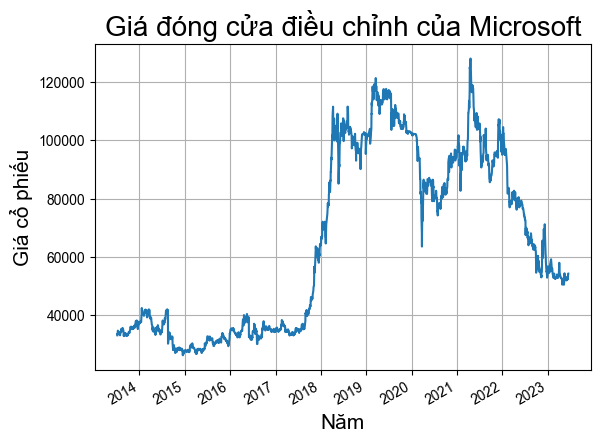

In [5]:
# Plot giá vào
# Chuyển đổi cột Date sang định dạng datetime
df = df.set_index("Date")
df['Adj Close'].plot(grid = True)
sns.set(rc={'figure.figsize':(15, 9)})
plt.title('Giá đóng cửa điều chỉnh của Microsoft', color = 'black', fontsize = 20)
plt.xlabel('Năm', color = 'black', fontsize = 15)
plt.ylabel('Giá cổ phiếu', color = 'black', fontsize = 15);

## 4. Đường trung bình động - Moving Average

Đường trung bình động là một chỉ số phân tích kỹ thuật đơn giản, theo đó quan sát tiếp theo là giá trị trung bình của tất cả các quan sát trong quá khứ tạo ra một mức giá trung bình được cập nhật liên tục.



In [6]:
# Tạo DataFrame cho Giá đóng cửa điều chỉnh

df1 = df[['Adj Close']]
df1

,Adj Close
Date,
2013-07-08,33144
2013-07-09,33678
2013-07-10,33411
2013-07-11,33946
2013-07-12,34747
...,...
2023-06-08,52400
2023-06-09,52300
2023-06-12,53400



### Split dữ liệu

Chúng ta sẽ chia dữ liệu thành train set và test set để xác minh kết quả dự đoán. Vì đây là dữ liệu dạng Time series nên ta không thể chia ngẫu nhiên được. Vậy nên là ta sẽ chia 80% đầu là train set và 20% còn lại là test set.

In [7]:
# Tạo split tỉ lệ 80%/20%

split = int(0.8*len(df1))

In [8]:
# Chia thành train và test set

train, test = df1[:split], df1[split:]

In [9]:
df1.shape, train.shape, test.shape

((2480, 1), (1984, 1), (496, 1))

In [10]:
train.index.min(), train.index.max(), test.index.min(), test.index.max()

(Timestamp('2013-07-08 00:00:00'),
 Timestamp('2021-06-18 00:00:00'),
 Timestamp('2021-06-21 00:00:00'),
 Timestamp('2023-06-14 00:00:00'))

### Tạo dự đoán cho test set

In [11]:
# Tạo dự đoán
preds = []
for i in range(0,496):
    a = train[len(train)-656+i:].sum() + sum(preds)
    b = a/656
    preds.append(b)

### Tính chỉ số RMSE 

Chúng ta sẽ đánh giá mô hình bằng cách tính toán chỉ số RMSE hoặc Độ lệch gốc-trung bình-bình phương (Root-mean-square deviation), một thước đo tốt để xem xét mức độ chính xác của các mô hình dự đoán phản hồi.

In [12]:
# Tính rmse
rmse = np.sqrt(np.mean(np.power((np.array(test)-preds),2)))
rmse

27294.453848090896

### Trực quan hóa các dữ liệu dự đoán và thực tế

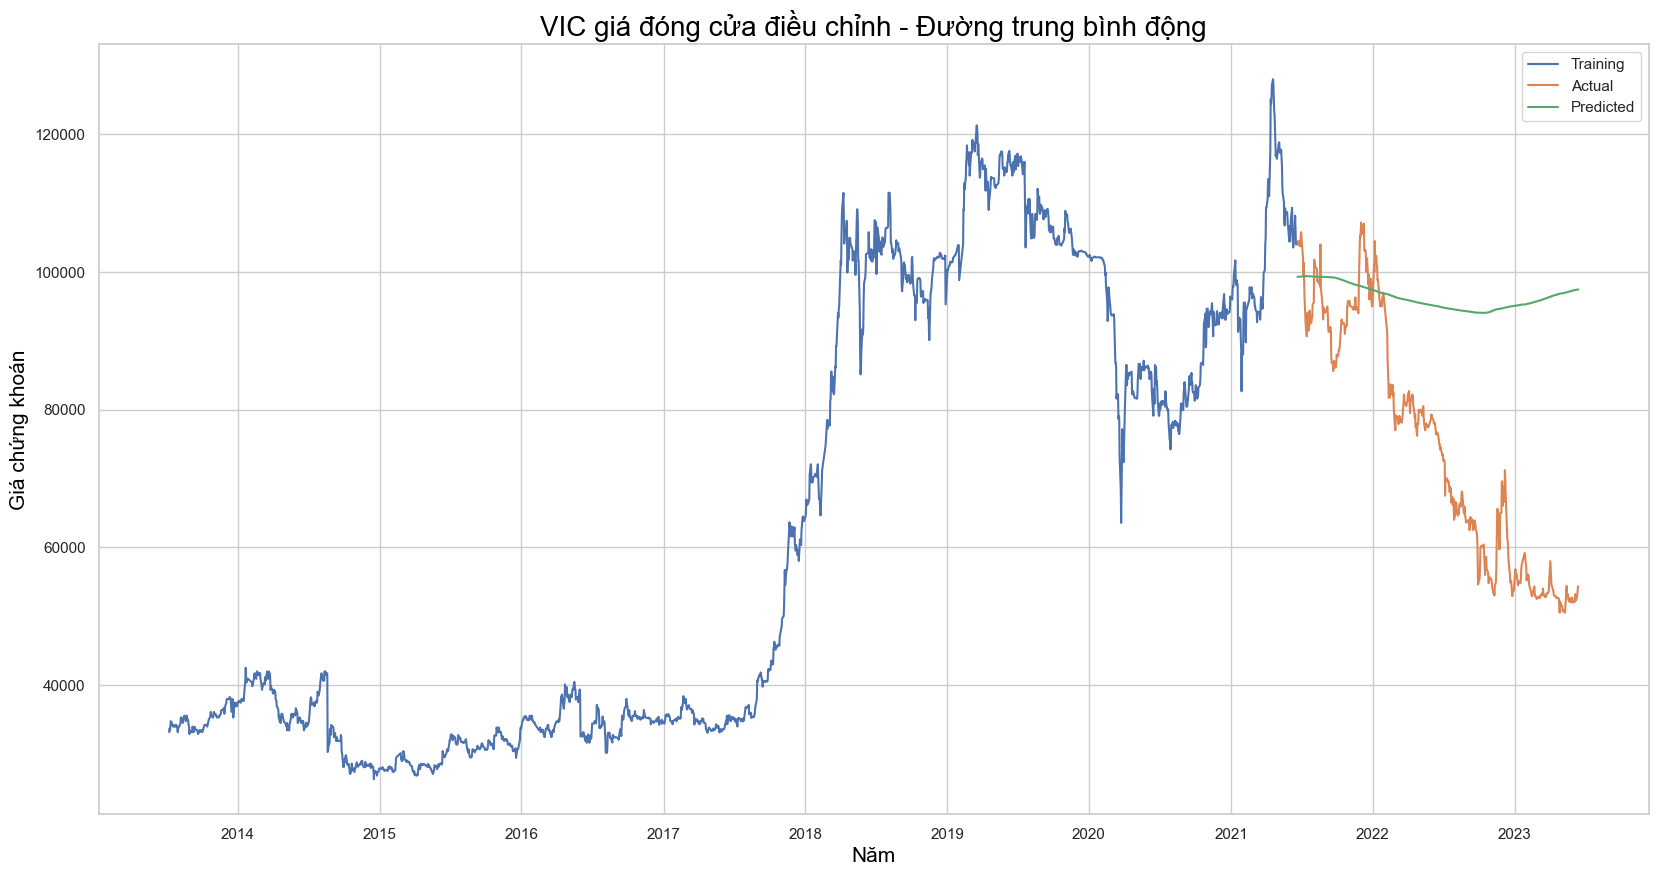

In [13]:
# Plot thông số dự đoán và thực tế
plt.figure(figsize=(20,10))
sns.set_style("whitegrid")
test['Predictions'] = 0
test['Predictions'] = preds
plt.plot(train, label='Training')
plt.plot(test['Adj Close'], label='Actual')
plt.plot(test['Predictions'], label='Predicted')
plt.title("VIC giá đóng cửa điều chỉnh - Đường trung bình động", color = 'black', fontsize = 20)
plt.xlabel('Năm', color = 'black', fontsize = 15)
plt.ylabel('Giá chứng khoán', color = 'black', fontsize = 15)
plt.legend();

Mô hình này cho thấy giá trị dự đoán không quá đúng, thực tế cho thấy giá giảm xuống quá nhiều so với giá dự đoán. Nhận xét ban đầu có thể là do tác động hậu covid, tình hình kinh tế trở nên khó khăn, lạm phát tăng mạnh làm cho giá cổ phiếu sụt giảm mạnh hơn so với tính toán kỹ thuật.

## 5. Hồi quy tuyến tính - Linear Regression

Mô hình này áp dụng cách tiếp cận tuyến tính để mô hình hóa mối quan hệ giữa biến phụ thuộc và (các) biến độc lập, đồng thời cũng là hình thức học máy đơn giản nhất.

In [14]:
df1['Date'] = pd.to_datetime(df1.index, format='%Y-%m-%d')
df1.index = df1['Date']

In [15]:
# Tạo tập dữ liệu riêng cho giá đóng cửa điều chỉnh
df1 = pd.DataFrame(index=range(0,len(df)),columns=['Date', 'Adj Close'])

for i in range(0,len(df)):
     df1['Date'][i] = df.index[i]
     df1['Adj Close'][i] = df['Adj Close'][i]

### Feature engineering (tạm dịch: Trích chọn đặc trưng)

Giả thuyết cho rằng, những ngày đầu tiên và cuối cùng trong tuần có khả năng ảnh hưởng nhiều đến giá đóng cửa điều chỉnh. Vì vậy chúng ta sẽ thêm một tính năng để phân loại các ngày dựa vào ngày trong tuần của chúng. 

Nếu số ngày là 0 (thứ hai) hoặc 4(thứ sáu) thì cột ghi chú sẽ hiện thị 1, và ngược lại, nếu ngày rơi vào thứ ba, tư, năm, cột hiện thị sẽ ghi là 0.

In [16]:
def add_datepart(data, fldname, drop=True, time=False):
    fld = data[fldname]
    fld_dtype = fld.dtype
    if isinstance(fld_dtype, pd.core.dtypes.dtypes.DatetimeTZDtype):
        fld_dtype = np.datetime64

    if not np.issubdtype(fld_dtype, np.datetime64):
        data[fldname] = fld = pd.to_datetime(fld, infer_datetime_format=True)
    targ_pre = re.sub('[Dd]ate$', '', fldname)
    attr = ['Year', 'Month', 'Week', 'Day', 'Dayofweek', 'Dayofyear',
            'Is_month_end', 'Is_month_start', 'Is_quarter_end', 'Is_quarter_start', 'Is_year_end', 'Is_year_start']
    if time: attr = attr + ['Hour', 'Minute', 'Second']
    for n in attr: data[targ_pre + n] = getattr(fld.dt, n.lower())
    data[targ_pre + 'Elapsed'] = fld.astype(np.int64) // 10 ** 9
    if drop: data.drop(fldname, axis=1, inplace=True)

In [17]:
# Gọi function để add cột vào
add_datepart(df1, 'Date')
df1.drop('Elapsed', axis=1, inplace=True) 

In [18]:
# Print cột
df1.columns

Index(['Adj Close', 'Year', 'Month', 'Week', 'Day', 'Dayofweek', 'Dayofyear',
       'Is_month_end', 'Is_month_start', 'Is_quarter_end', 'Is_quarter_start',
       'Is_year_end', 'Is_year_start'],
      dtype='object')

In [19]:
# Tạo tính năng
df1['mon_fri'] = 0
for i in range(0,len(df1)):
    if (df1['Dayofweek'][i] == 0 or df1['Dayofweek'][i] == 4):
        df1['mon_fri'][i] = 1
    else:
        df1['mon_fri'][i] = 0

### Split data thành train và test set 

In [20]:
split = int(0.8*len(df1))

In [21]:
train, test = df1[:split], df1[split:]

In [22]:
df1.shape, train.shape, test.shape

((2480, 14), (1984, 14), (496, 14))

In [23]:
X_train = train.drop('Adj Close', axis=1)
y_train = train['Adj Close']
X_test = test.drop('Adj Close', axis=1)
y_test = test['Adj Close']

In [24]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((1984, 13), (1984,), (496, 13), (496,))

### Tạo và train mô hình Hồi quy tuyến tính


In [25]:
# Tạo model
model = LinearRegression()

# Train model
model.fit(X_train,y_train)

LinearRegression()

### Test model

In [26]:
# Tạo dự báo 
preds = model.predict(X_test)

### Tính chỉ số RMSE

In [27]:
rmse = np.sqrt(np.mean(np.power((np.array(y_test)-np.array(preds)),2)))
rmse

55850.42702276799

### Trực quan hóa các dữ liệu dự đoán và thực tế

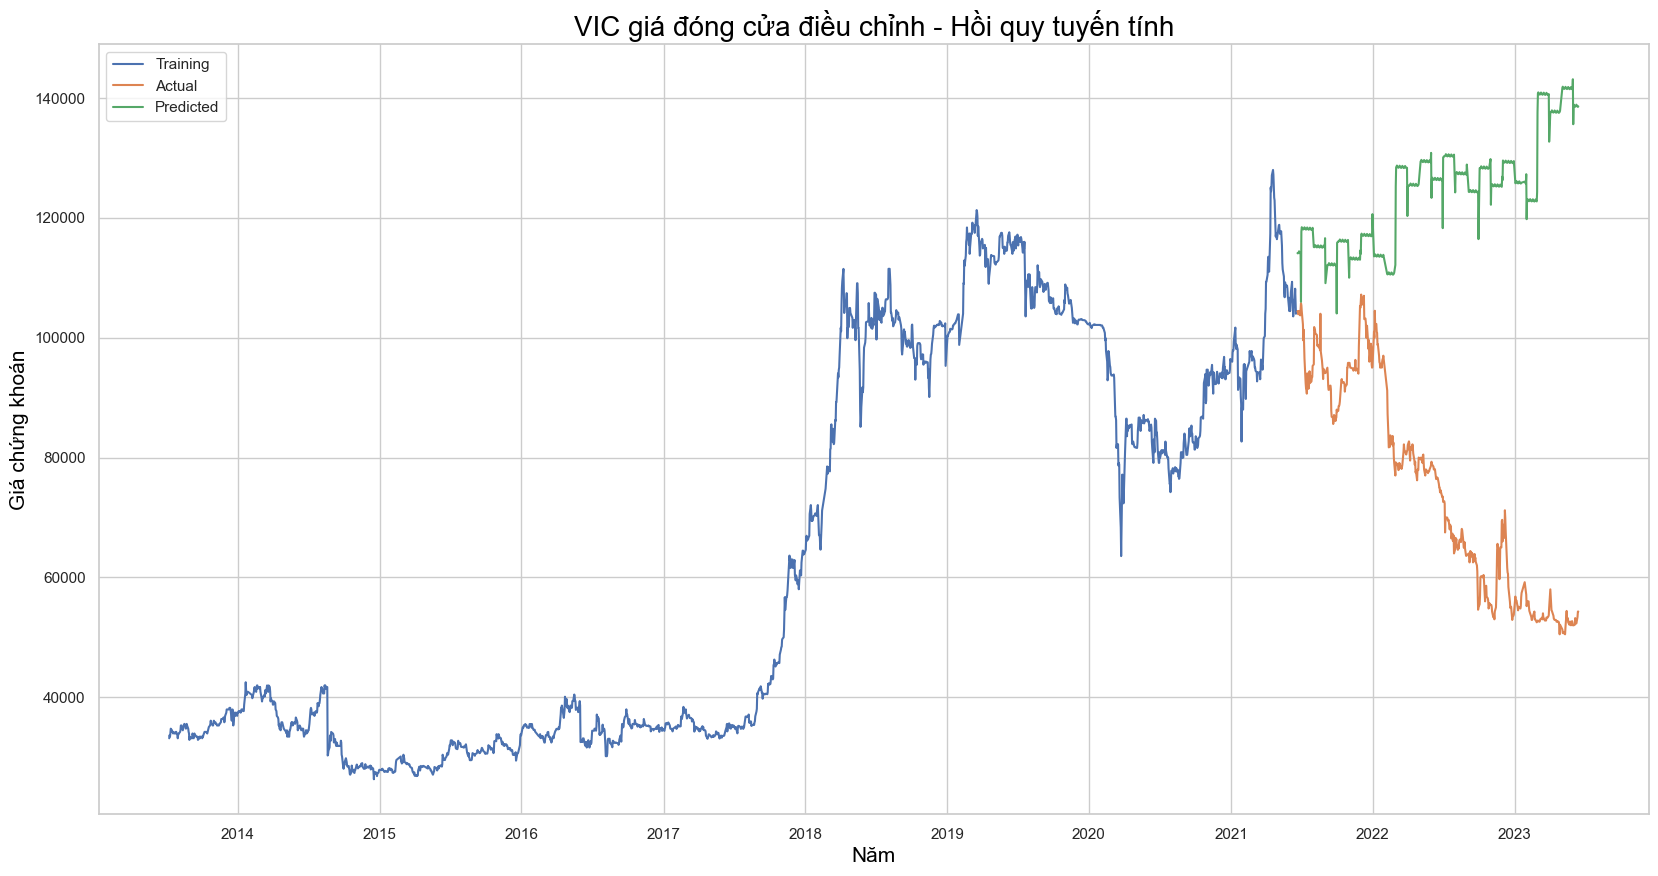

In [28]:
# Plot thông số dự đoán và thực tế
plt.figure(figsize=(20,10))
sns.set_style("whitegrid")
test['Predictions'] = 0
test['Predictions'] = preds

test.index = df[split:].index
train.index = df[:split].index

plt.plot(train['Adj Close'], label='Training')
plt.plot(test['Adj Close'], label='Actual')
plt.plot(test['Predictions'], label='Predicted')
plt.title("VIC giá đóng cửa điều chỉnh - Hồi quy tuyến tính", color = 'black', fontsize = 20)
plt.xlabel('Năm', color = 'black', fontsize = 15)
plt.ylabel('Giá chứng khoán', color = 'black', fontsize = 15)
plt.legend();

Giá trị RMSE cao hơn so với Đường trung bình động quá nhiều. Đồ thị cho thấy mô hình Hồi quy tuyến tính vẫn có vẻ không tốt khi dự đoán và thực tế gần như trái ngược nhau, 

## 6. k-Nearest Neighbours

Dựa trên các biến độc lập, k-Nearest Neighbors tìm thấy sự giống nhau giữa các điểm dữ liệu mới, cũ và giả định rằng các điểm dữ liệu tương tự tồn tại ở gần nhau. Nó chọn k cho “hàng xóm” gần nhất và sau đó dựa trên những “hàng xóm” này để dự đoán một giá trị cho quan sát mới. k-Nearest Neighbours được biết đến như là một mô hình machine learning đơn giản. 

### Feature scaling (tạm dịch: Scaling trích chọn)

In [29]:
# Normalisation - thay đổi tỷ lệ dữ liệu để tất cả các giá trị nằm trong phạm vi 0 và 1
scaler = MinMaxScaler(feature_range=(0, 1))

X_train_scaled = scaler.fit_transform(X_train)
X_train = pd.DataFrame(X_train_scaled)
X_test_scaled = scaler.transform(X_test) 
X_test = pd.DataFrame(X_test_scaled)

### GridSearch tìm tham số tối ưu

In [30]:
# Tạo thư viện cho tham số
params = {'n_neighbors':[2,3,4,5,6,7,8,9]}
# Tạo model
knn = KNeighborsRegressor()
# Dùng GridSearch để tìm tham số tối ưu
model = GridSearchCV(knn, params, cv=5)

### Train và test model

In [31]:
# Fit model và tạo dự đoán
model.fit(X_train,y_train)
preds = model.predict(X_test)

### Tính chỉ số RMSE

In [32]:
rmse = np.sqrt(np.mean(np.power((np.array(y_test)-np.array(preds)),2)))
rmse

28576.29493561642

### Trực quan hóa các dữ liệu dự đoán và thực tế

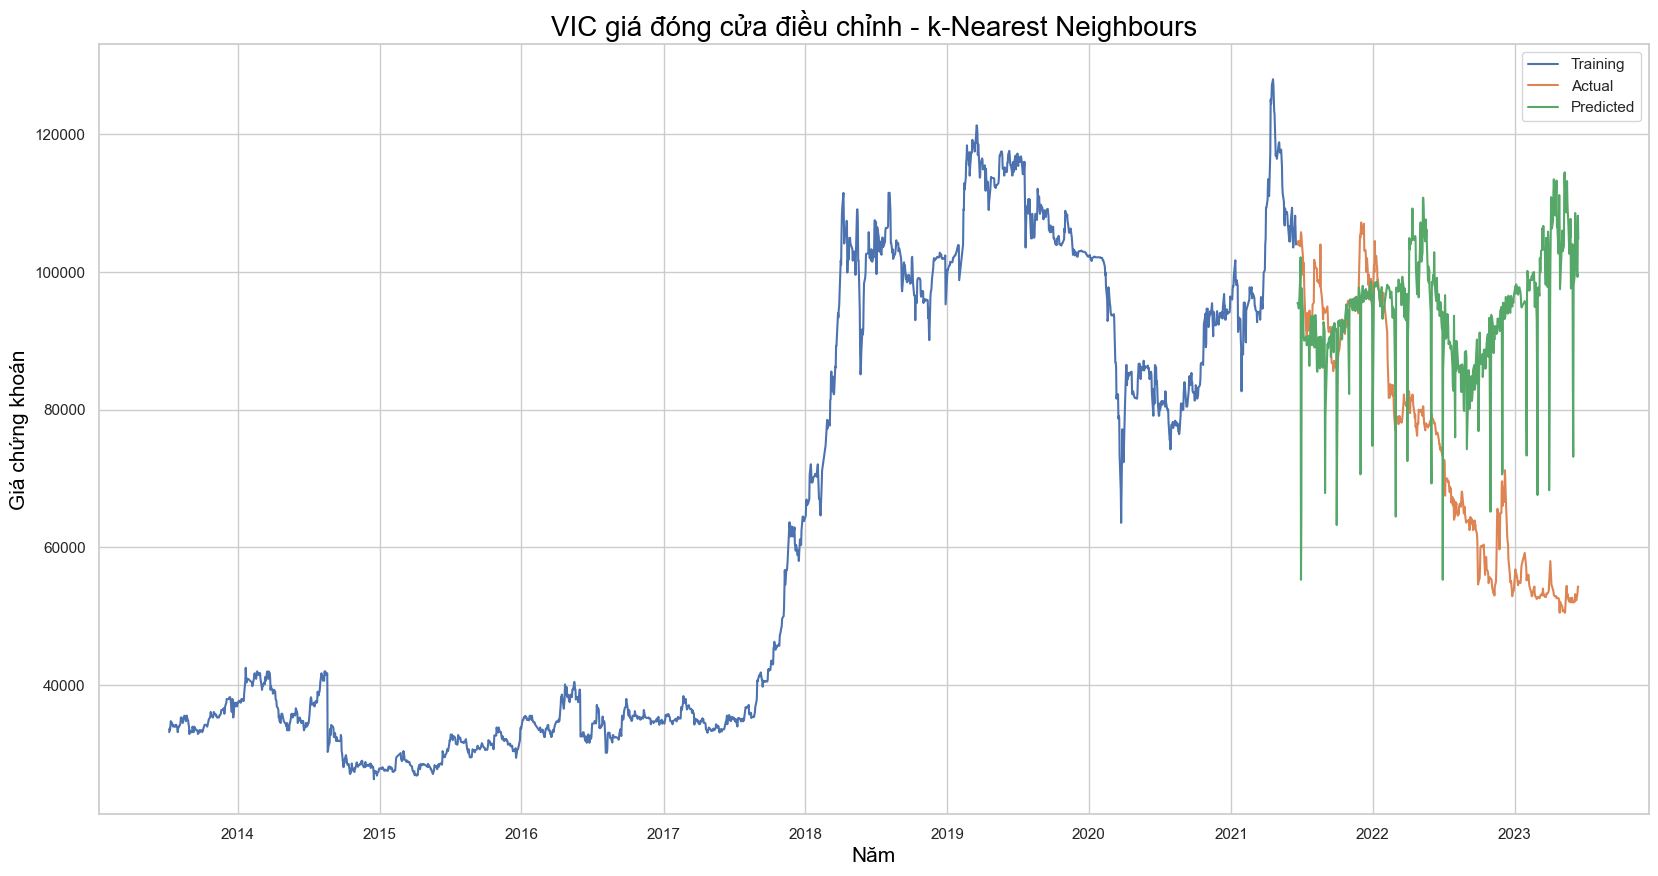

In [33]:
# Plot thông số dự đoán và thực tế
plt.figure(figsize=(20,10))
sns.set_style("whitegrid")
test['Predictions'] = 0
test['Predictions'] = preds

plt.plot(train['Adj Close'], label='Training')
plt.plot(test['Adj Close'], label='Actual')
plt.plot(test['Predictions'], label='Predicted')
plt.title("VIC giá đóng cửa điều chỉnh - k-Nearest Neighbours", color = 'black', fontsize = 20)
plt.xlabel('Năm', color = 'black', fontsize = 15)
plt.ylabel('Giá chứng khoán', color = 'black', fontsize = 15)
plt.legend();

Từ ba biểu đồ trên, có thể thấy mô hình K-Nearest hoạt động tốt nhất trong 3 mô hình này. Nhưng kết quả từ giữa năm 2022 đến qua năm 2023 không quá khả quan khi xu hướng dự đoán của giá cổ phiếu VIC gần như khác hết giá thực tế.

Bằng cách sử dụng dữ liệu trong quá khứ để phân tích và hiểu được các hình mẫu trong chuỗi thời gian, các mô hình đã nắm bắt được xu hướng ngày càng tăng trong chuỗi và đạt đến được RMSE thấp nhất cho đến hiện tại. Tuy nhiên tỉ lệ sai số vẫn còn khá cao và hiệu suất vẫn còn thấp.


## 8. Prophet

Tiếp theo, chúng ta sẽ sử dụng một mô hình phân tích và dự đoán của dữ liệu chuỗi thời gian có tính đến cả xu hướng và tính thời vụ của tập dữ liệu. Prophet là một gói dự báo dữ liệu chuỗi thời gian dựa trên mô hình cộng trong đó các xu hướng phi tuyến tính phù hợp với tính thời vụ hàng năm, hàng tuần và hàng ngày, cộng với cả các tác nhân ảnh hưởng bên ngoài như các dịp đặc biệt.

### Chuẩn bị và định dạng dữ liệu

In [34]:
# Tạo data set với cột Giá đóng cửa điều chỉnh và cột ngày
df1 = pd.DataFrame(index=range(0,len(df)),columns=['Date', 'Adj Close'])

for i in range(0,len(df)):
     df1['Date'][i] = df.index[i]
     df1['Adj Close'][i] = df['Adj Close'][i]

In [35]:
# Định dạng ngày
df1['Date'] = pd.to_datetime(df1.Date,format='%Y-%m-%d')
df1.index = df1['Date']

In [36]:
# Định dạng dữ liệu
df1.rename(columns={'Adj Close': 'y', 'Date': 'ds'}, inplace=True)

Dữ liệu đầu vào của Prophet được cài đặt là một khung dữ liệu có hai cột: **ds** và **y**. Cột ds (datestamp) phải được định dạng theo pandas là YYYY-MM-DD cho điểm dữ liệu. Cột y là số và đại diện cho phép đo mà chúng ta muốn dự báo.

### Split data thành train và test sets

In [37]:
split = int(0.8*len(df1))

In [38]:
train, test = df1[:split], df1[split:]

In [39]:
df1.shape, train.shape, test.shape

((2480, 2), (1984, 2), (496, 2))

### Tạo và train model

In [40]:
# Tạo mô hình Prophet  
model = Prophet()
# Fit model
model.fit(train)

08:55:27 - cmdstanpy - INFO - Chain [1] start processing
08:55:29 - cmdstanpy - INFO - Chain [1] done processing


### Test model

Sau đó, dự đoán được thực hiện trên DataFrame với cột **ds** chứa ngày dự đoán sẽ được thực hiện. 

In [41]:
# Tạo dự báo  
adj_close_prices = model.make_future_dataframe(periods=len(test))
forecast = model.predict(adj_close_prices)

### Tính chỉ số RMSE

In [42]:
forecast_test = forecast['yhat'][split:]
rmse = np.sqrt(np.mean(np.power((np.array(test['y'])-np.array(forecast_test)),2)))
rmse

26390.189002855404

### Trực quan hóa các dữ liệu dự đoán và thực tế

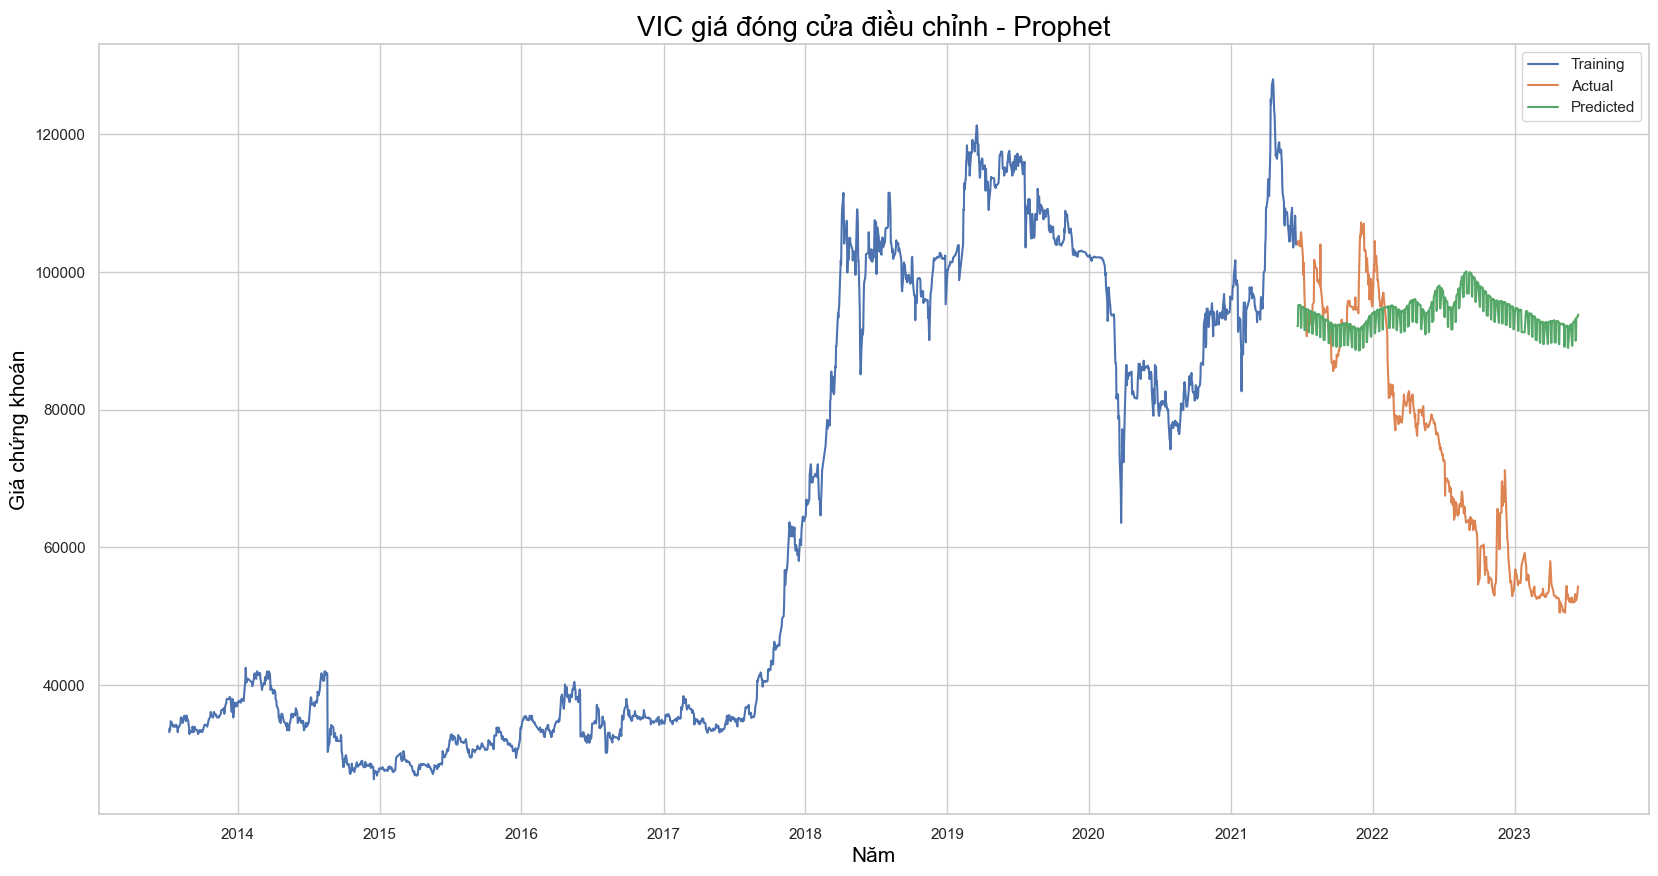

In [43]:
# Plot thông số dự đoán và thực tế
test['Predictions'] = 0
test['Predictions'] = forecast_test.values

plt.figure(figsize=(20,10))
sns.set_style("whitegrid")
plt.plot(train['y'], label='Training')
plt.plot(test['y'], label='Actual')
plt.plot(test['Predictions'], label='Predicted')
plt.title("VIC giá đóng cửa điều chỉnh - Prophet", color = 'black', fontsize = 20)
plt.xlabel('Năm', color = 'black', fontsize = 15)
plt.ylabel('Giá chứng khoán', color = 'black', fontsize = 15)
plt.legend();

Đặc tính của giá cổ phiếu đó là giá của cổ phiếu sẽ biến động phụ thuộc nhiều vào các lực lượng ảnh hưởng của thị trường, vì vậy thường là chúng sẽ không có một xu hướng thực sự cụ thể trong thời gian dài hay có tính thời vụ. Do đó, các kỹ thuật dự báo như Prophet (hay SARIMA ít nhiều có tính tương đồng) thường sẽ không mang lại kết quả quá khả quan khi áp dụng cho vấn đề này, mặc dù rằng chúng vẫn thể hiện tốt hơn nhiều so với các mô hình hồi quy truyền thống.

Tuy nhiên, nói như vậy không có nghĩ là Prophet hoàn toàn không thể dự đoán được các dạng dữ liệu thời gian không có tính thời vụ hay xu hướng. Thư viện Prophet cung cấp cho người dùng một thuật toán gọi là prophet_make_future_dataframe, trong đó mô hình sẽ dự đoán dữ liệu trong 365 ngày tiếp theo, với các mốc changepoint (dữ liệu thay đổi) trong quá khứ. Tuy không thực sự mang tính thời vụ đều đặn, nhưng khi dự đoán dữ liệu mới qua các mốc thời gian tương ứng ở những năm trước này, Prophet sẽ cân nhắc chúng vào các biến số và ước lượng để cho ra một kết quả dự đoán chính xác hơn.

In [44]:
future = model.make_future_dataframe(periods=365)
future.tail()

,ds
2344,2022-06-14
2345,2022-06-15
2346,2022-06-16
2347,2022-06-17
2348,2022-06-18


In [45]:
# Tạo dự đoán cho 365 ngày trong tương lai
forecast = model.predict(future)

Mô hình dự đoán sẽ gán cho mỗi hàng trong tương lai một giá trị dự đoán và đặt tên nó là **yhat**. Nếu mô hình chạy vượt qua các ngày này trong lịch sử, nó sẽ cung cấp một sự điều chỉnh đối với mẫu. Đối tượng dự báo ở đây là một DataFrame mới bao gồm một cột yhat với dự báo, cũng như các cột cho các thành phần và các khoảng không chắc chắn.

In [46]:
# Print dự đoán DataFrame

forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
2344,2022-06-14,95737.178492,77558.707418,115419.628871
2345,2022-06-15,95604.770602,77518.779988,115371.575520
2346,2022-06-16,95789.524610,77714.758411,115744.450194
2347,2022-06-17,95756.391757,77185.239460,115956.129094
2348,2022-06-18,92538.692112,73051.808769,112569.065900


### Trực quan hóa dự báo và các điểm thay đổi xu hướng

Dữ liệu chuỗi thời gian thường có những thay đổi đột ngột trong khuynh hướng chuyển động của chúng. Vì vậy, Prophet sẽ tự động phát hiện ra những điểm thay đổi này và sẽ cho phép điều chỉnh các xu hướng một cách thích hợp hơn.

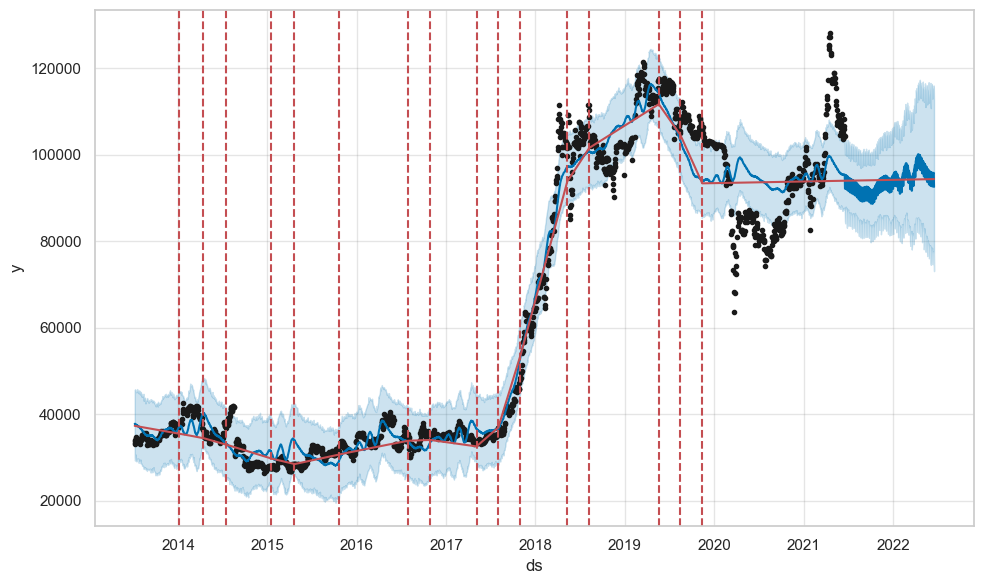

In [47]:
# Plot dự đoán
fig = model.plot(forecast)
# Thêm các điểm thay đổi xu hướng vô  
a = add_changepoints_to_plot(fig.gca(), model, forecast)

### Trích xuất các điểm thay đổi

Những điểm dưới đây thể hiện các mốc thay đổi xu hướng của dữ liệu

In [48]:
model.changepoints

63     2013-10-04
127    2014-01-03
190    2014-04-14
254    2014-07-16
317    2014-10-15
381    2015-01-15
444    2015-04-22
508    2015-07-27
571    2015-10-23
634    2016-01-21
698    2016-04-28
761    2016-07-28
825    2016-10-27
888    2017-01-25
952    2017-05-05
1015   2017-08-02
1078   2017-10-31
1142   2018-02-01
1205   2018-05-11
1269   2018-08-09
1332   2018-11-07
1396   2019-02-14
1459   2019-05-20
1523   2019-08-16
1586   2019-11-14
Name: ds, dtype: datetime64[ns]

### Trực quan hoá các thành phần của dự báo


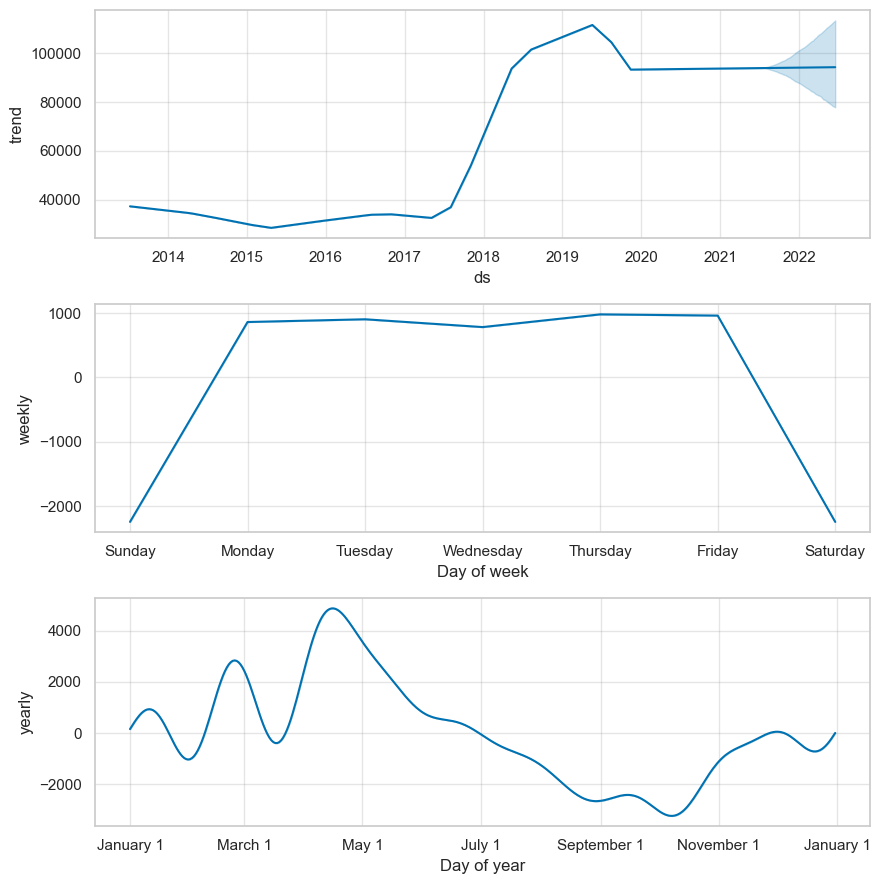

In [49]:
# Trực quan xu hướng, thành phần tuần, năm

model.plot_components(forecast)
plt.show()

Dựa trên các xu hướng ước tính, chúng ta có thể thấy từ ô phụ hàng năm rằng, thông thường, giá cổ phiếu dường như đạt mức cao nhất vào khoản tháng 4 và tháng 5 và giảm mạnh vào tháng 6, 7, 8, 9. theo ô phụ hàng tuần, các thứ trong tuần đều có biến động gần giồng nhau.
Cuối cùng, biểu đồ con xu hướng cho thấy giá cổ phiếu không biết động nhiều đặn trong thời gian dự đoán. Tuy nhiên thực tế thì giá cổ phiếu giảm mạnh.

## 9. Long Short Term Memory (LSTM)

LSTM là một Recurrent Neural Network (tạm dịch: Mạng thần kinh tái phát) có thể lưu trữ những thông tin quan trọng trong quá khứ và quên đi những thông tin không quan trọng. Nó sử dụng các quy trình bộ nhớ ngắn hạn để tạo ra bộ nhớ dài hơn và giới thiệu khái niệm về cổng để kiểm soát luồng thông tin trong mạng lưới bằng cách có cơ chế cổng đầu vào, đầu ra và cổng quên.

In [51]:
# Tạo DataFrame cho Giá đóng cửa điều chỉnh
df1 = df[['Adj Close']]
df1

,Adj Close
Date,
2013-07-08,33144
2013-07-09,33678
2013-07-10,33411
2013-07-11,33946
2013-07-12,34747
...,...
2023-06-08,52400
2023-06-09,52300
2023-06-12,53400


In [53]:
# Chuyển DataFrame thành numpy array
df1_arr = df1.values

### Split data thành train và test set

In [55]:
split = int(0.8*len(df1_arr))

In [56]:
train, test = df1_arr[:split], df1_arr[split:]

In [57]:
train.shape, test.shape

((1984, 1), (496, 1))

### Feature scaling 

Tiêu chuẩn hoá dữ liệu bằng cách scale dữ liệu thành định dạng từ 0 đến 1 để cải thiện việc học và tính hội tụ của mô hình.

In [59]:
# Scaling trích chọn và fit dữ liệu scale
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(df1_arr)

## Tạo dữ liệu training

In [60]:
# Tạo cấu trúc dữ liệu với 60 time-steps và 1 output 

X_train, y_train = [], []
for i in range(60,len(train)):
    X_train.append(scaled_data[i-60:i,0])
    y_train.append(scaled_data[i,0])

In [61]:
# Chuyển X_train và y_train thành numpy arrays cho mô hình LSTM training 

X_train, y_train = np.array(X_train), np.array(y_train)

In [62]:
# Chuyển dạng dữ liệu thành 3D theo định dạng yêu cầu của LSTM (samples, time steps, features)

X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_train.shape

(1924, 60, 1)

### Tạo và train model

Chúng ta sẽ triển khai một mô hình đơn giản bao gồm một lớp ẩn với 50 nơ-ron, hình dạng dữ liệu đầu vào với số bước thời gian (number of time steps) là (60) và số chiều (dimensionality) là (1) và một lớp đầu ra với bước thời gian là 1. Mô hình sẽ được biên dịch bằng Mean Squared Error (MSE) và trình tối ưu hóa ADAM (Adaptive Moment Estimation), sau đó sẽ được fit với training set với một epoch và batch size là một.

In [64]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM


In [65]:
# Tạo và fit mạng LSTM 
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1],1)))
model.add(LSTM(units=50))
model.add(Dense(1))

model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(X_train, y_train, epochs=1, batch_size=1, verbose=2)

# Dự đoán 504 giá trị, sự dụng 60 từ tập data train 
inputs = df1_arr [len(df1_arr) - len(test) - 60:]
inputs = inputs.reshape(-1,1)
inputs  = scaler.transform(inputs)

1924/1924 - 35s - loss: 0.0022 - 35s/epoch - 18ms/step


### Tạo test set và test

In [66]:
# Tạo test data set
X_test = []
for i in range(60,inputs.shape[0]):
    X_test.append(inputs[i-60:i,0])

# Chuyển data thành numpy array
X_test = np.array(X_test)

# Chuyển data thành 3-D
X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))
adj_closing_price = model.predict(X_test)
adj_closing_price = scaler.inverse_transform(adj_closing_price)

16/16 [==============================] - 1s 13ms/step


In [67]:
print(X_test.shape)

(496, 60, 1)


### Tính chỉ số RMSE

In [68]:
rmse = np.sqrt(np.mean(np.power((test - adj_closing_price),2)))
rmse

2605.233245718303

### Trực quan hóa các dữ liệu dự đoán và thực tế

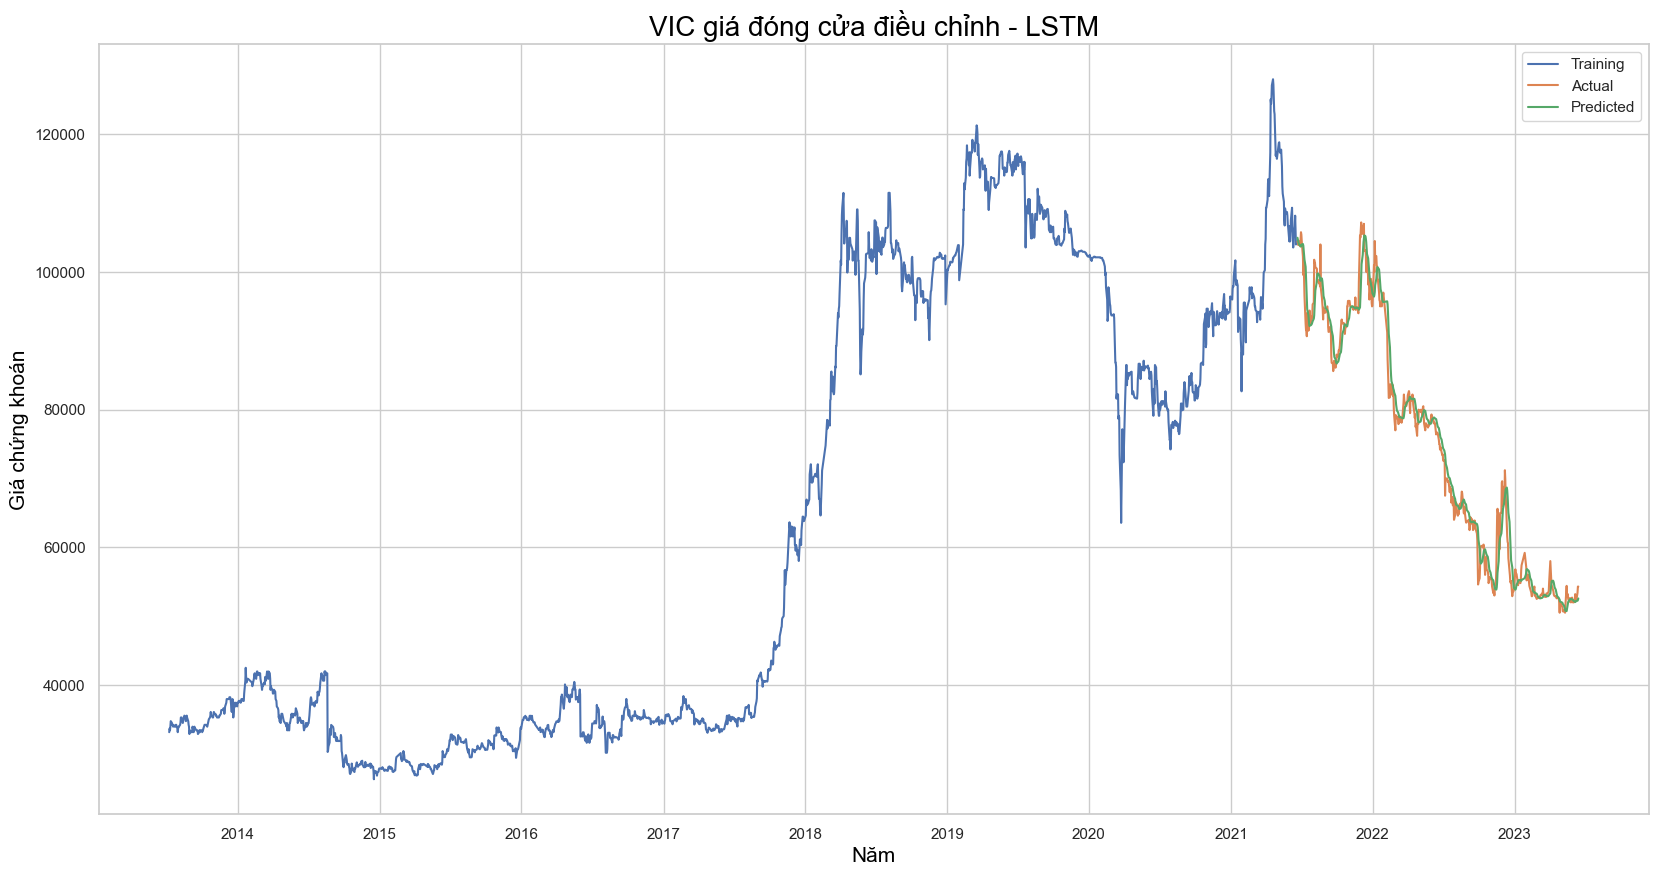

In [69]:
# Plot thông số dự đoán và thực tế
train = df1[:split]
test = df1[split:]
test['Predictions'] = adj_closing_price

plt.figure(figsize=(20,10))
sns.set_style("whitegrid")
plt.plot(train['Adj Close'], label='Training')
plt.plot(test['Adj Close'], label='Actual')
plt.plot(test['Predictions'], label='Predicted')
plt.title("VIC giá đóng cửa điều chỉnh - LSTM", color = 'black', fontsize = 20)
plt.xlabel('Năm', color = 'black', fontsize = 15)
plt.ylabel('Giá chứng khoán', color = 'black', fontsize = 15)
plt.legend();

Mô hình LSTM đã đạt được giá trị RMSE thấp nhất và dự đoán chính xác nhất. Dù rằng đây chỉ là một mô hình deep learning cơ bản song chúng ta có thể tiếp tục điều chỉnh nhiều tham số khác nhau, nhiều lớp có thể được thêm vào với các tính năng để chuẩn hóa và tăng số lượng epochs để mô hình có tính hội tụ tốt hơn.